In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [76]:
import numpy as np
import numpy.linalg as la

#matplotlib.use("module://matplotlib-backend-kitty")

#np.set_printoptions(threshold=0)

%matplotlib inline

In [77]:
cities = np.genfromtxt("csv/Argentina.csv", delimiter=",")
cities = cities[1:, 1:]
n_cities = cities.shape[0]
n_cities

9152

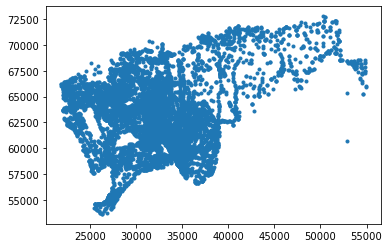

In [78]:
plt.scatter(cities[:, 0], cities[:, 1], marker=".")

In [79]:
def d(i, j):
    return np.linalg.norm(cities[i, :] - cities[j, :])

In [80]:
d(0, 1)

4256.53097343104

In [81]:
class Individual:
    def __init__(self, genome):
        self.genome = genome
        self.fitness = sum(
            [d(genome[i], genome[i + 1]) for i in range(0, len(genome) - 1)]
        ) + d(genome[len(genome) - 1], genome[0])

    # Muta al individuo
    def mutate(self):
        genome = np.copy(self.genome)
        i, j = np.random.choice(len(genome), size=2, replace=False)
        genome[i], genome[j] = genome[j], genome[i]
        return Individual(genome)

    # Two point crossover
    def cross(self, q):
        child = np.copy(self.genome)
        start, end = np.sort(np.random.choice(len(child), size=2, replace=False))
        child[:start] = child[end + 1 :] = -1
        child[child == -1] = np.setdiff1d(q.genome, child, assume_unique=True)
        return Individual(child)

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __gt__(self, other):
        return self.fitness > other.fitness

    def __repr__(self):
        return "Individual(genome: {0}, fitness: {1})".format(
            self.genome.__str__(), self.fitness
        )

In [82]:
i = Individual(np.array([0, 5, 10, 15]))
i.fitness

20607.95743028738

In [83]:
o = i.mutate()
o.genome, o.fitness, i.genome, i.fitness

(array([ 5,  0, 10, 15]),
 22230.650041935845,
 array([ 0,  5, 10, 15]),
 20607.95743028738)

In [84]:
a = Individual(np.array([1, 2, 3, 4, 5]))
b = Individual(np.array([2, 1, 3, 5, 4]))
c = a.cross(b)
a.genome, b.genome, c.genome

(array([1, 2, 3, 4, 5]), array([2, 1, 3, 5, 4]), array([1, 2, 3, 4, 5]))

In [85]:
# DEPRECATED: Lo generaliza greedy_popuation con ratio=0
def random_population(n_population):
    # TODO: Generar individuos aleatorios
    return np.array(
        [Individual(np.random.permutation(n_cities)) for _ in range(n_population)]
    )

In [86]:
def greedy_popuation(n_population, ratio=1 / 2):
    """
    Genera población parte aleatoria parte generada mediante nearest neighbours

    Args:
        n_population: Tamaño total de la población
        ratio: Qué porcentaje de la población se genera greedily. 0 -> toda random
    """
    # Guardamos la población generada en population
    population = []

    # Primero generamos los de nearest neighbours
    n_greedy = round(n_population * ratio)
    n_random = n_population - n_greedy

    for _ in range(n_greedy):
        # Anotamos las ciudades visitadas modificando una copia de la lista de ciudades. Las
        # visitadas se vuelven nan. Asi se excluyen del cálculo de distancias.
        visitados = []
        index = range(len(cities))
        # Elegimos ciudad al azar
        curr_city = np.random.randint(0, len(cities))
        visitados.append(curr_city)
        city_record = np.copy(cities)

        while len(visitados) != len(index):
            city_record[curr_city] = np.nan

            distancias = la.norm(city_record - cities[curr_city], axis=1)
            # Tomamos la ciudad más cercana como actual
            curr_city = np.nanargmin(distancias)
            visitados.append(curr_city)

        # Añadiendo el individuo a la población
        population.append(Individual(visitados))

    # Generamos el resto de la población aleatoriamente
    population = population + [
        Individual(np.random.permutation(n_cities)) for _ in range(n_random)
    ]
    return np.array(population)

In [87]:
# El de menor fitness es el que tiene más probabilidades de reproducirse
def calculate_wheel_probability(population):
    fitnesses = np.array([p.fitness for p in population])
    # fitnesses = np.min(fitnesses) + np.max(fitnesses) - fitnesses
    # return fitnesses / np.sum(fitnesses)
    fitnesses = np.max(fitnesses) + 1 - fitnesses
    s = np.sum(fitnesses)
    return fitnesses / s

In [88]:
calculate_wheel_probability([i, o])

array([9.99384499e-01, 6.15501045e-04])

In [89]:
def GA(
    n_population=100,
    n_generation=1000,
    cross_rate=0.3,
    mutate_rate=0.2,
    greedy_rate=0,
    verbose=False,
    print_interval=10,
):
    """
    Resuelve el problema del agente viajero mediante una versión modificada de la estrategia del 
    algoritmos genéticos. Se genera una población del tamaño especificado y con las características 
    de aleatoriedad deseadas.

    Args:
        n_population: Tamaño total de la población
        n_generation: Número de generaciones
        cross_rate:
        mutate_rate:
        greedy_rate: Porcentaje de la población inicial que se genera mediante nearest neighbours
        verbose: Controla la cantidad de información que imprime el algoritmo
    """
    # Para la generación 0
    # Pk = random_population(n_population)
    history = []
    Pk = greedy_popuation(n_population, greedy_rate)
    best_individual = Pk[Pk.argmin()]
    for k in range(1, n_generation):
        # Creamos la siguiente generacion
        Pk_next = np.array([])
        # Para seleccionar usamos wheel roulette selection
        # Calculamos la wheel probability
        wheel_prob = calculate_wheel_probability(Pk)
        # 1. Copy: seleccionamos (1 − cross_rate) × n individuos de Pk y los insertamos en Pk+1
        Pk_next = np.append(
            Pk_next,
            np.random.choice(
                Pk, round((1 - cross_rate) * n_population), p=wheel_prob, replace=True
            ),
        )
        # 2. Crossover: seleccionamos (cross_rate * n) parejas de Pk y los cruzamos para añadirlos en Pk+1
        parejas = np.random.choice(
            Pk, 2 * round(cross_rate * n_population), p=wheel_prob, replace=True
        ).reshape(-1, 2)
        Pk_next = np.append(Pk_next, [p.cross(q) for p, q in parejas])

        # 3. Mutate: seleccionamos mutate_rate de la población Pk+1 y la mutamos
        mutate_index = np.random.choice(
            len(Pk_next), int(mutate_rate * len(Pk_next)), replace=True
        )
        Pk_next[mutate_index] = np.array([x.mutate() for x in Pk_next[mutate_index]])

        # Acualizamos la generación
        Pk = Pk_next
        if Pk[Pk.argmin()] < best_individual:
            best_individual = Pk[Pk.argmin()]
        
        history.append(best_individual.fitness)
        # Imprimimos status
        if verbose is True or k % print_interval == 0:
            print(f"Generation {k}: {best_individual}")
            
    return best_individual,history

In [90]:
best_individual,history = GA(n_population=23, n_generation=10,verbose=True)

Generation 1: Individual(genome: [6491 8538 5759 ... 3963  603 6434], fitness: 73385364.99639645)
Generation 2: Individual(genome: [6491 8538 5759 ... 3963  603 6434], fitness: 73385364.99639645)
Generation 3: Individual(genome: [6491 8538 5759 ... 3963  603 6434], fitness: 73385364.99639645)
Generation 4: Individual(genome: [6491 8538 5759 ... 3963  603 6434], fitness: 73385364.99639645)
Generation 5: Individual(genome: [4361 7170 5853 ... 7594 2698 2221], fitness: 73190866.7330965)
Generation 6: Individual(genome: [4378 6222 8163 ... 8762 1152 5831], fitness: 73098807.33630024)
Generation 7: Individual(genome: [4378 6222 8163 ... 8762 1152 5831], fitness: 73098807.33630024)
Generation 8: Individual(genome: [4378 6222 8163 ... 8762 1152 5831], fitness: 72996222.30421172)
Generation 9: Individual(genome: [4378 6222 8163 ... 8762 1152 5831], fitness: 72996222.30421172)


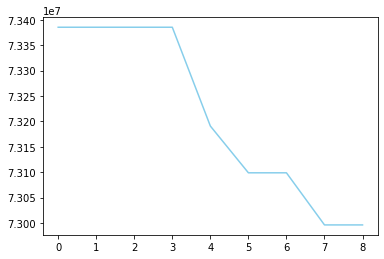

In [91]:
history
plt.plot(range(len(history)), history, color="skyblue")

In [93]:
best_individual,history = GA(n_population=20, n_generation=10, greedy_rate=1 / 5, verbose=True)

Generation 1: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 2: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 3: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 4: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 5: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 6: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 7: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 8: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

Generation 9: Individual(genome: [168, 4923, 4841, 1786, 7261, 1807, 7953, 4917, 6426, 6574, 8669, 6427, 8169, 169, 7309, 7375, 793, 794, 4552, 6331, 7353, 4600, 7362, 7314, 2638, 4588, 4071, 1274, 1909, 1911, 7962, 8203, 199, 1299, 1300, 1318, 4681, 6844, 2720, 4615, 379, 4664, 3768, 2725, 3559, 8504, 3706, 5053, 5894, 7246, 450, 451, 7164, 6335, 214, 6719, 694, 7038, 1916, 2721, 6918, 7342, 8123, 7292, 3893, 438, 3615, 7960, 419, 427, 2096, 7007, 1459, 6416, 2132, 7950, 7958, 2740, 2741, 7963, 3268, 2183, 2298, 6612, 3474, 3779, 3782, 4391, 1812, 3230, 217, 6350, 4367, 2634, 6525, 1051, 2337, 6271, 6404, 1181, 2328, 4619, 4554, 6314, 4873, 6706, 4119, 2322, 3071, 1112, 4406, 7701, 6716, 8877, 176, 672, 3204, 3209, 4496, 4073, 6393, 4723, 5301, 5302, 3978, 4398, 3958, 3959, 8124, 6975, 506, 6906, 4081, 1465, 1473, 1025, 1026, 5279, 3208, 4727, 4394, 4397, 509, 5280, 6893, 4293, 4294, 352, 2053, 4314, 4362, 8034, 8047, 8177, 2751, 9057, 1562, 1409, 7334, 8864, 1626, 1966, 8027, 4667, 8

In [94]:
history

[1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752,
 1059318.0214968752]